In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../Data/NYCTaxiFares.csv")

In [3]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


First, study the fare amount

In [4]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

In order to extract important information from pickup and drop off longitutde and latitude, we must get the haversine distance

In [5]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [6]:
 # feature engineering
df['dist_km'] = haversine_distance(df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

correlation between the distance and the fare amount

In [7]:
df['dist_km'].corr(df['fare_amount'])

0.8961572062237243

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
pickup_datetime      120000 non-null object
fare_amount          120000 non-null float64
fare_class           120000 non-null int64
pickup_longitude     120000 non-null float64
pickup_latitude      120000 non-null float64
dropoff_longitude    120000 non-null float64
dropoff_latitude     120000 non-null float64
passenger_count      120000 non-null int64
dist_km              120000 non-null float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


First Convert the pickup date time 

In [9]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime']) - pd.Timedelta(hours=4)

In [10]:
df['Hour'] = df['EDTdate'].dt.hour

In [11]:
df['Weekday'] = df['EDTdate'].dt.strftime("%a")

In [12]:
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')

In [13]:
cat_cols = ['Hour', 'Weekday','AMorPM']
con_cols = ['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km']
label_cols = ['fare_amount']

In [14]:
for field in cat_cols:
    df[field] = df[field].astype('category')

In [15]:
df['Hour'].cat.codes

0          4
1         11
2          7
3         17
4         22
          ..
119995    10
119996     6
119997    14
119998     4
119999    12
Length: 120000, dtype: int8

In [16]:
cats = torch.LongTensor(np.stack([df[cat].cat.codes.values for cat in cat_cols], axis=1))

In [17]:
cons = torch.FloatTensor(np.stack([df[con].values for con in con_cols], axis=1))

In [18]:
labels = torch.tensor(df[label_cols].values, dtype=torch.float).reshape(-1,1)

In [19]:
cat_sizes = [len(df[col].cat.categories) for col in cat_cols]

In [20]:
emb_sizes = [(size, min(50,(size+1)//2)) for size in cat_sizes]

In [21]:
cats_2 = cats[:2]

In [22]:
cats_2

tensor([[ 4,  1,  0],
        [11,  2,  0]])

In [23]:
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sizes])

In [24]:
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(7, 4)
  (2): Embedding(2, 1)
)

In [25]:
# Forward Method for all the categorical data
embedding_2 = []
for i, e in enumerate(selfembeds):
    embedding_2.append(e(cats_2[:,i]))

In [26]:
embedding_2

[tensor([[-0.6009, -1.1960,  0.9173, -1.1688, -0.7362, -1.6747, -0.0847,  0.0431,
          -2.8461,  1.6196, -0.5084, -0.5345],
         [ 1.2913,  0.5308,  0.0653,  1.2694, -1.6166,  0.0658,  0.1648,  1.5506,
          -0.9599, -1.1574, -0.9491, -0.0614]], grad_fn=<EmbeddingBackward>),
 tensor([[-1.4413, -0.6399, -0.8672, -0.0893],
         [-0.8213,  0.0097, -0.3834,  0.0771]], grad_fn=<EmbeddingBackward>),
 tensor([[0.8251],
         [0.8251]], grad_fn=<EmbeddingBackward>)]

In [27]:
z = torch.cat(embedding_2, dim=1)

In [28]:
z

tensor([[-0.6009, -1.1960,  0.9173, -1.1688, -0.7362, -1.6747, -0.0847,  0.0431,
         -2.8461,  1.6196, -0.5084, -0.5345, -1.4413, -0.6399, -0.8672, -0.0893,
          0.8251],
        [ 1.2913,  0.5308,  0.0653,  1.2694, -1.6166,  0.0658,  0.1648,  1.5506,
         -0.9599, -1.1574, -0.9491, -0.0614, -0.8213,  0.0097, -0.3834,  0.0771,
          0.8251]], grad_fn=<CatBackward>)

In [29]:
selfembdrop = nn.Dropout(p=.4)

In [30]:
z = selfembdrop(z)

In [31]:
z.shape

torch.Size([2, 17])

In [32]:
l = nn.BatchNorm1d(3)
t = torch.tensor([[1,2,3],[2,2,3],[3,3,3]], dtype=torch.float)
print(l(t))

tensor([[-1.2247, -0.7071,  0.0000],
        [ 0.0000, -0.7071,  0.0000],
        [ 1.2247,  1.4142,  0.0000]], grad_fn=<NativeBatchNormBackward>)


In [33]:
class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        """
        layers: You can define how many neurons you want for each layers
        """
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum([nf for ni, nf in emb_szs])
        n_in = n_emb + n_cont
        
        # Set up layers
        for layer in layers:
            layerlist.append(nn.Linear(n_in, layer))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(layer))
            layerlist.append(nn.Dropout(p))
            n_in = layer
        
        layerlist.append(nn.Linear(layers[-1], out_sz))
        
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_cat, x_cont):
        embeddings = []
        
        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        
        x = torch.cat(embeddings,1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x,x_cont], axis=1)
        x = self.layers(x)
        return x

In [34]:
torch.manual_seed(33)
model = TabularModel(emb_sizes, cons.shape[1], 1, [200,100], p=.4)
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()

In [35]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(7, 4)
    (2): Embedding(2, 1)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [36]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [37]:
batch_size = 60000
test_size = int(batch_size*.2)

In [38]:
# Data was shuffled before I even loaded
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = cons[:batch_size-test_size]
con_test = cons[batch_size-test_size:batch_size]

In [39]:
y_train = labels[:batch_size-test_size]
y_test = labels[batch_size-test_size:batch_size]

In [40]:
len(cat_train)

48000

In [41]:
len(con_train)

48000

In [42]:
len(cat_test)

12000

In [43]:
len(con_test)

12000

In [47]:
import time

start_time = time.time()

epochs = 300

losses = []

for epoch in range(epochs):
    if CUDA:
        cat_train = cat_train.cuda()
        con_train = con_train.cuda()
        y_train = y_train.cuda()
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # Root MSE
    losses.append(loss)
    
    if (epoch + 1) % 20 == 0:
        print("Epoch [{}/{}]. Loss is {}".format(epoch+1, epochs, loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
duration = time.time() - start_time
print('Training took {} seconds'.format(duration))

Epoch [20/300]. Loss is 11.177725791931152
Epoch [40/300]. Loss is 10.480367660522461
Epoch [60/300]. Loss is 10.057403564453125
Epoch [80/300]. Loss is 9.656950950622559
Epoch [100/300]. Loss is 9.194202423095703
Epoch [120/300]. Loss is 8.604644775390625
Epoch [140/300]. Loss is 7.8199992179870605
Epoch [160/300]. Loss is 6.949066638946533
Epoch [180/300]. Loss is 5.9756760597229
Epoch [200/300]. Loss is 5.058892250061035
Epoch [220/300]. Loss is 4.336621284484863
Epoch [240/300]. Loss is 3.9483532905578613
Epoch [260/300]. Loss is 3.8272716999053955
Epoch [280/300]. Loss is 3.7460451126098633
Epoch [300/300]. Loss is 3.674163818359375
Training took 14.275737524032593 seconds


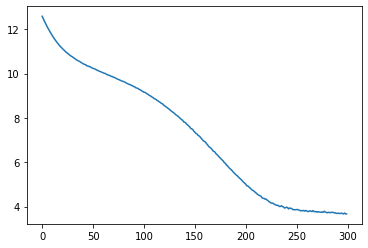

In [48]:
plt.plot(range(epochs), losses)

In [50]:
with torch.no_grad():
    if CUDA:
        cat_test = cat_test.cuda()
        con_test = con_test.cuda()
        y_test = y_test.cuda()
    y_val = model(cat_test,con_test)
    
    loss = torch.sqrt(criterion(y_val, y_test))

In [51]:
loss

tensor(3.6262, device='cuda:0')

In [55]:
for i in range(30):
    print(f"{i}) PREDICTED : {y_val[i].item():8.2f}. TRUE : {y_test[i].item():8.2f}")

0) PREDICTED :     6.47. TRUE :     2.90
1) PREDICTED :    20.85. TRUE :     5.70
2) PREDICTED :     6.00. TRUE :     7.70
3) PREDICTED :    16.87. TRUE :    12.50
4) PREDICTED :     4.78. TRUE :     4.10
5) PREDICTED :     6.05. TRUE :     5.30
6) PREDICTED :     3.44. TRUE :     3.70
7) PREDICTED :    16.47. TRUE :    14.50
8) PREDICTED :     2.60. TRUE :     5.70
9) PREDICTED :    12.80. TRUE :    10.10
10) PREDICTED :     7.75. TRUE :     4.50
11) PREDICTED :     6.59. TRUE :     6.10
12) PREDICTED :     9.56. TRUE :     6.90
13) PREDICTED :    13.35. TRUE :    14.10
14) PREDICTED :     4.67. TRUE :     4.50
15) PREDICTED :    34.96. TRUE :    34.10
16) PREDICTED :     2.42. TRUE :    12.50
17) PREDICTED :     6.40. TRUE :     4.10
18) PREDICTED :     7.78. TRUE :     8.50
19) PREDICTED :     6.20. TRUE :     5.30
20) PREDICTED :    11.79. TRUE :    11.30
21) PREDICTED :    10.11. TRUE :    10.50
22) PREDICTED :    12.57. TRUE :    15.30
23) PREDICTED :    15.24. TRUE :    14.90
24

In [56]:
torch.save(model.state_dict(),'TaxiModel.pt')